# Random Forest Classifer for News Data

## Idea:

Implement a RFC for our news dataset, however we faced an initial complication:

- Our feature variables are text and RFC only can use floating point numbers for classification

## Solution

Use gloVe word embeddings to embed every word in the title and the description, then use an aggregatation method to hopefully collate enough information to use for prediction. In the code below we have simply averaged the word embeddings.

In [2]:
import pandas as pd
import numpy as np
import csv

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint

from tensorflow.keras.preprocessing.text import Tokenizer

data = []
words = []

with open('train.csv') as f:
  reader = csv.reader(f)
  next(reader)
  for row in reader:

    # Tokenisation of words for embedding creation
    t = int(row[0])
    title = row[1].split()
    title = [t.lower() for t in title]
    description = row[2].split()
    description = [d.lower() for d in description]
    try:
      words.extend(t.lower() for t in title)
    except:
      pass

    data.append([t,title,description])

2024-04-16 12:32:30.842145: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/simonklaassen/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [4]:
# create the dict and tokenize the words
tokenizer = Tokenizer()
tokenizer.fit_on_texts(words)

In [7]:
# Creates a dictionary that maps each unique word to an idx.
print("Number of unique words in dictionary = ",len(tokenizer.word_index))
first_ten_entries = {key: tokenizer.word_index[key] for key in list(tokenizer.word_index.keys())[:10]}
print("The first ten entries of the dictionary are = ", first_ten_entries)

Number of unique words in dictionary =  36752
The first ten entries of the dictionary are =  {'to': 1, 'in': 2, '39': 3, 'for': 4, 'on': 5, 'of': 6, 's': 7, 'ap': 8, 'the': 9, 'b': 10}


In [9]:
# Download and unzip the pre-trained gloVe word embeddings

!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove*.zip

/bin/bash: wget: command not found


unzip:  cannot find or open glove*.zip, glove*.zip.zip or glove*.zip.ZIP.

No zipfiles found.


In [62]:
# Create a embedding_matrix, which has for each word in our word_index a corresponding
# Embedding of size 50.

def embedding_for_vocab(filepath, word_index,
                        embedding_dim):
    vocab_size = len(word_index) + 1

    # Adding again 1 because of reserved 0 index
    embedding_matrix_vocab = np.zeros((vocab_size,
                                       embedding_dim))

    with open(filepath, encoding="utf8") as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word]
                embedding_matrix_vocab[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix_vocab


# matrix for vocab: word_index
embedding_dim = 50
embedding_matrix_vocab = embedding_for_vocab(
    'glove.6B.50d.txt', tokenizer.word_index,
  embedding_dim)

print("Dense vector for the first word is => ",
      embedding_matrix_vocab[1])

Dense vector for first word is =>  [ 0.68046999 -0.039263    0.30186    -0.17792     0.42962     0.032246
 -0.41376001  0.13228001 -0.29846999 -0.085253    0.17117999  0.22419
 -0.10046    -0.43652999  0.33418     0.67846     0.057204   -0.34448001
 -0.42785001 -0.43274999  0.55962998  0.10032     0.18677001 -0.26853999
  0.037334   -2.09319997  0.22171    -0.39868     0.20912001 -0.55725002
  3.88260007  0.47466001 -0.95657998 -0.37788001  0.20869    -0.32752001
  0.12751     0.088359    0.16350999 -0.21634001 -0.094375    0.018324
  0.21048    -0.03088    -0.19722     0.082279   -0.09434    -0.073297
 -0.064699   -0.26043999]


In [77]:
# For a list of strings gather their respective word embeddings then average them

def get_list_embedding(list, embedding_matrix, vocab_idx):

  title_embedding = []

  for word in list:
    if word in vocab_idx:

      idx = vocab_idx[word]
      embedding = embedding_matrix[idx]
      title_embedding.append(embedding)


  return np.mean(title_embedding)


print(get_list_embedding(["the","lazy","dog"], embedding_matrix_vocab, tokenizer.word_index))

for d in data:
  d[1] = get_list_embedding(d[1], embedding_matrix_vocab, tokenizer.word_index)
  d[2] = get_list_embedding(d[2],embedding_matrix_vocab, tokenizer.word_index)


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [95]:
# Data => Train, test split

data = pd.DataFrame(data, columns = ("Target","Title","Description"))

print(data.shape)
data = data.dropna()


X = data.drop("Target", axis = 1)
y = data["Target"]

# Train split

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2)


(119890, 3)


In [92]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier()

In [102]:
y_pred = rf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)

print("Accuracy:", accuracy)

Accuracy: 0.8662106931353741


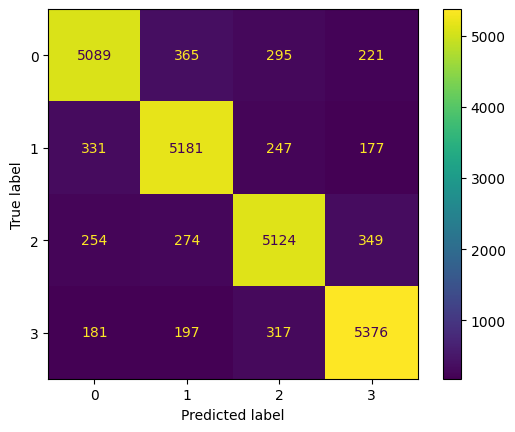

In [98]:
cm = confusion_matrix(y_test,y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm).plot()

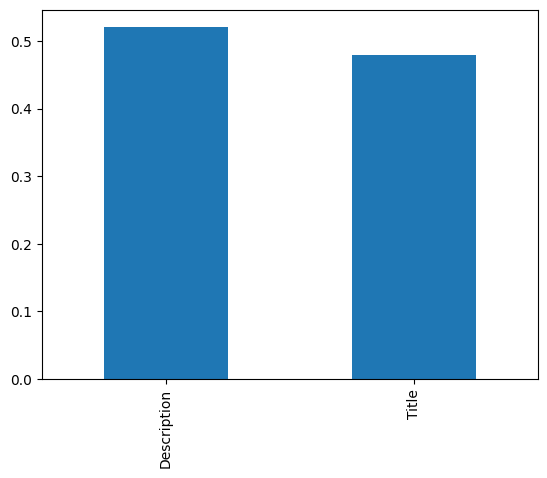

In [104]:
# Create a series containing feature importances from the model and feature names from the training data
feature_importances = pd.Series(rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)

# Plot a simple bar chart
feature_importances.plot.bar()

**Questions**

***Conceptual***

- Is our approach to translating the input data to numerical data ok? Any recommendations on how we could potentially do better? Is averaging fine?
- Are the GloVe word embeddings the best embeddings for this purpose?

***Implementation***

- If a word appears in the dataset, but not in the GloVe embeddings (e.g. because it is a typo, as an example see printed dictionary - single letters), then its GloVe is by default an array of 0s. Is this a problem?
- Set up a directory in Google Colab where we can access the Random-Forest Classifier and later also the LAAM notebook? Makes it easier to run it + faster thanks to Dario's subscription.
- Why embeddings of size 50? According to the paper, performance is better for embeddings of a larger size.
- Can we do a naive train/test split? Or do we have to balance the targets in the train and test datasets?
    - Based on the confusion matrix, it seems like the samples are nicely balanced.